## **Credit Card Fraud Detection Using Kernel Density Estimation**

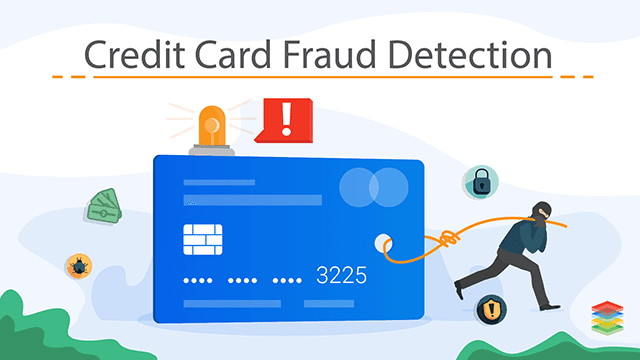


**Credit card fraud detection is the process of identifying and preventing fraudulent activities related to credit card transactions.**

## Data Collection

In this project, we will work with **Credit Card Fraud Dataset**.

The Dataset is existed on kaggle: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

Information about dataset:
The dataset contains transactions made by credit cards in September 2013 by European cardholders.

This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

To get the dataset from kaggle we need to follow the below instructions.

Use below code to upload your kaggle.json to colab environment (you can download kaggle.json from your Profile->Account->API Token)

In [ ]:
from google.colab import files
files.upload()

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# fetch and download the dataset
!kaggle datasets download -d mlg-ulb/creditcardfraud

In [4]:
# unzip the file and extract the data file
!unzip -q /content/creditcardfraud.zip

## Exploritory Data Analysis

In [1]:
#import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
# fetch the dataset and read it as pandas DataFrame
data = pd.read_csv("creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
print("There are {rows} rows and {cols} columns in the dataset.".format(rows=data.shape[0], cols=data.shape[1]))

There are 284807 rows and 31 columns in the dataset.


In [4]:
# get general information about data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [5]:
# check if there are missing values
data.isnull().sum().max()

0

Fortunately, the dataset does not contain missing values.

In [6]:
# get descriptive statistics about data
data.describe().apply(lambda s: s.apply('{0:.6f}'.format))

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,...,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000
mean,94813.859575,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,...,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,88.349619,0.001727
std,47488.145955,1.958696,1.651309,1.516255,1.415869,1.380247,1.332271,1.237094,1.194353,1.098632,...,0.734524,0.725702,0.624460,0.605647,0.521278,0.482227,0.403632,0.330083,250.120109,0.041527
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,54201.500000,-0.920373,-0.598550,-0.890365,-0.848640,-0.691597,-0.768296,-0.554076,-0.208630,-0.643098,...,-0.228395,-0.542350,-0.161846,-0.354586,-0.317145,-0.326984,-0.070840,-0.052960,5.600000,0.000000
50%,84692.000000,0.018109,0.065486,0.179846,-0.019847,-0.054336,-0.274187,0.040103,0.022358,-0.051429,...,-0.029450,0.006782,-0.011193,0.040976,0.016594,-0.052139,0.001342,0.011244,22.000000,0.000000
75%,139320.500000,1.315642,0.803724,1.027196,0.743341,0.611926,0.398565,0.570436,0.327346,0.597139,...,0.186377,0.528554,0.147642,0.439527,0.350716,0.240952,0.091045,0.078280,77.165000,0.000000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,...,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000


The table above shows us:
1. Outliers are present in almost all of the variables.
2. Mean and median are slightly different in some features which indicate that there are skewness in the data.


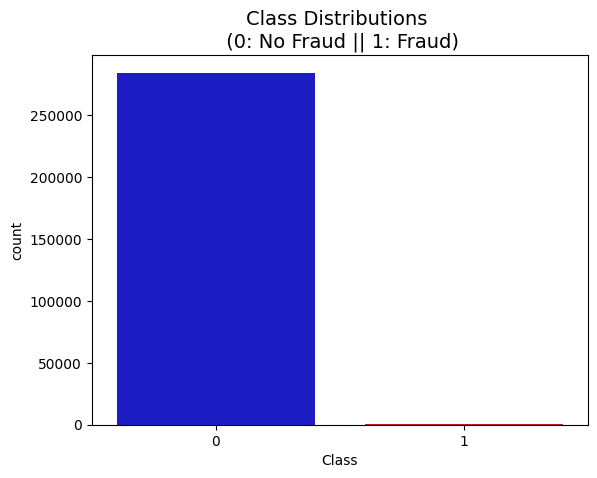

In [7]:
# display the distribution of class column
colors = ["#0101DF", "#DF0101"]
sns.countplot(data, x='Class', palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14);

In [8]:
data["Class"].value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

Look at how unbalanced our original dataset is! The majority of transactions are non-fraudulent. If we utilize this dataframe as the foundation for our predictive models and analysis, we may encounter numerous errors, and our algorithms will likely overfit because they will "assume" that the majority of transactions are not fraudulent. However, we do not want our model to make assumptions; instead, we want it to identify patterns that indicate potential fraud.

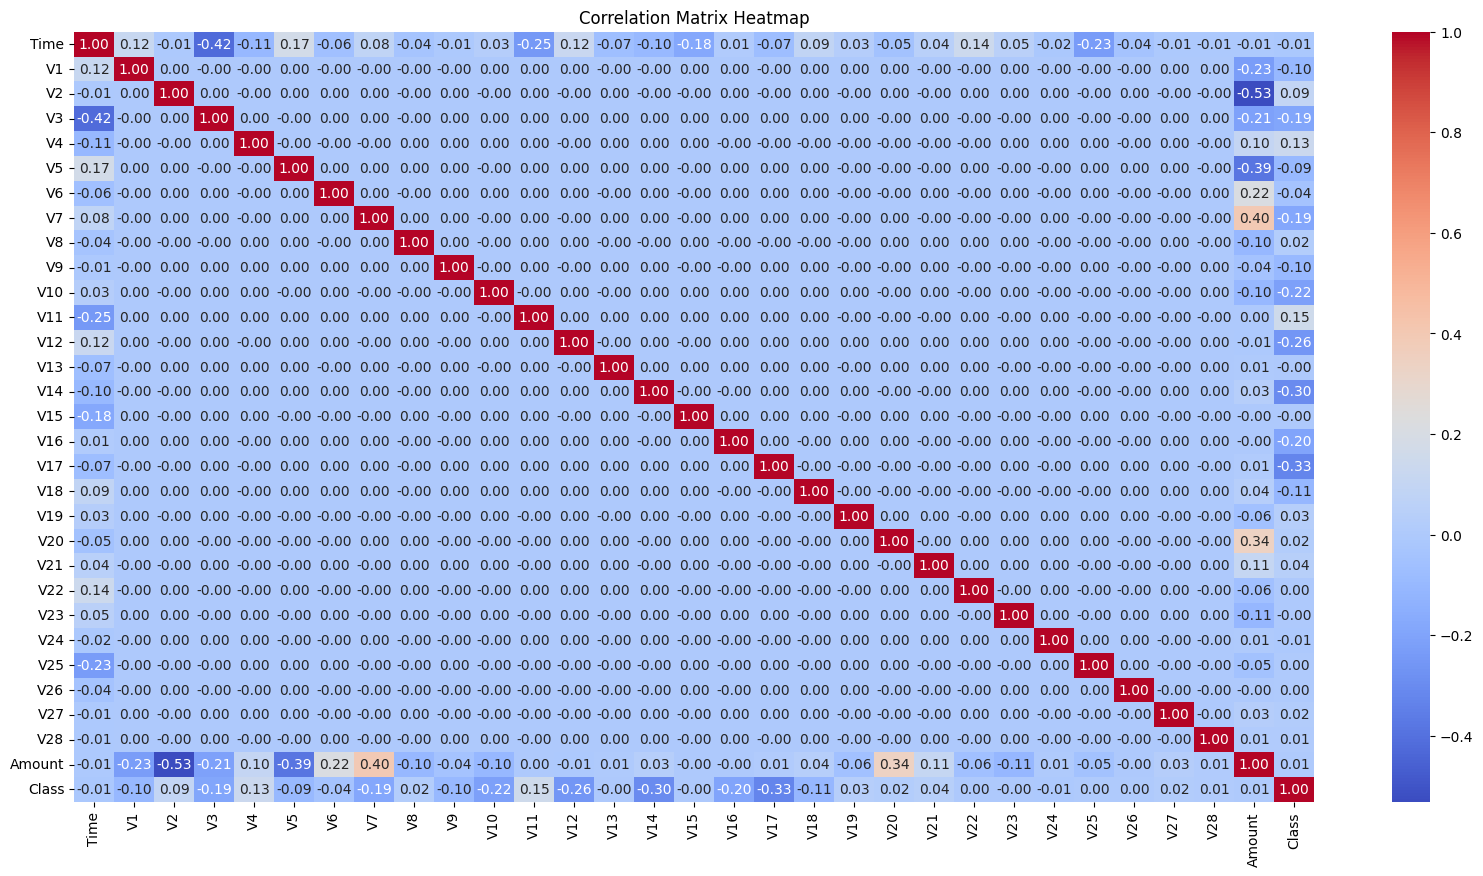

In [9]:
# create a correlation matrix between features
correlation_matrix = data.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

Due to the significant imbalance in the dataset, it might not possible to draw meaningful insights from the correlation matrix.

**Solution:** The class 0 dataset can be reduced to match the size of the class 1 dataset.

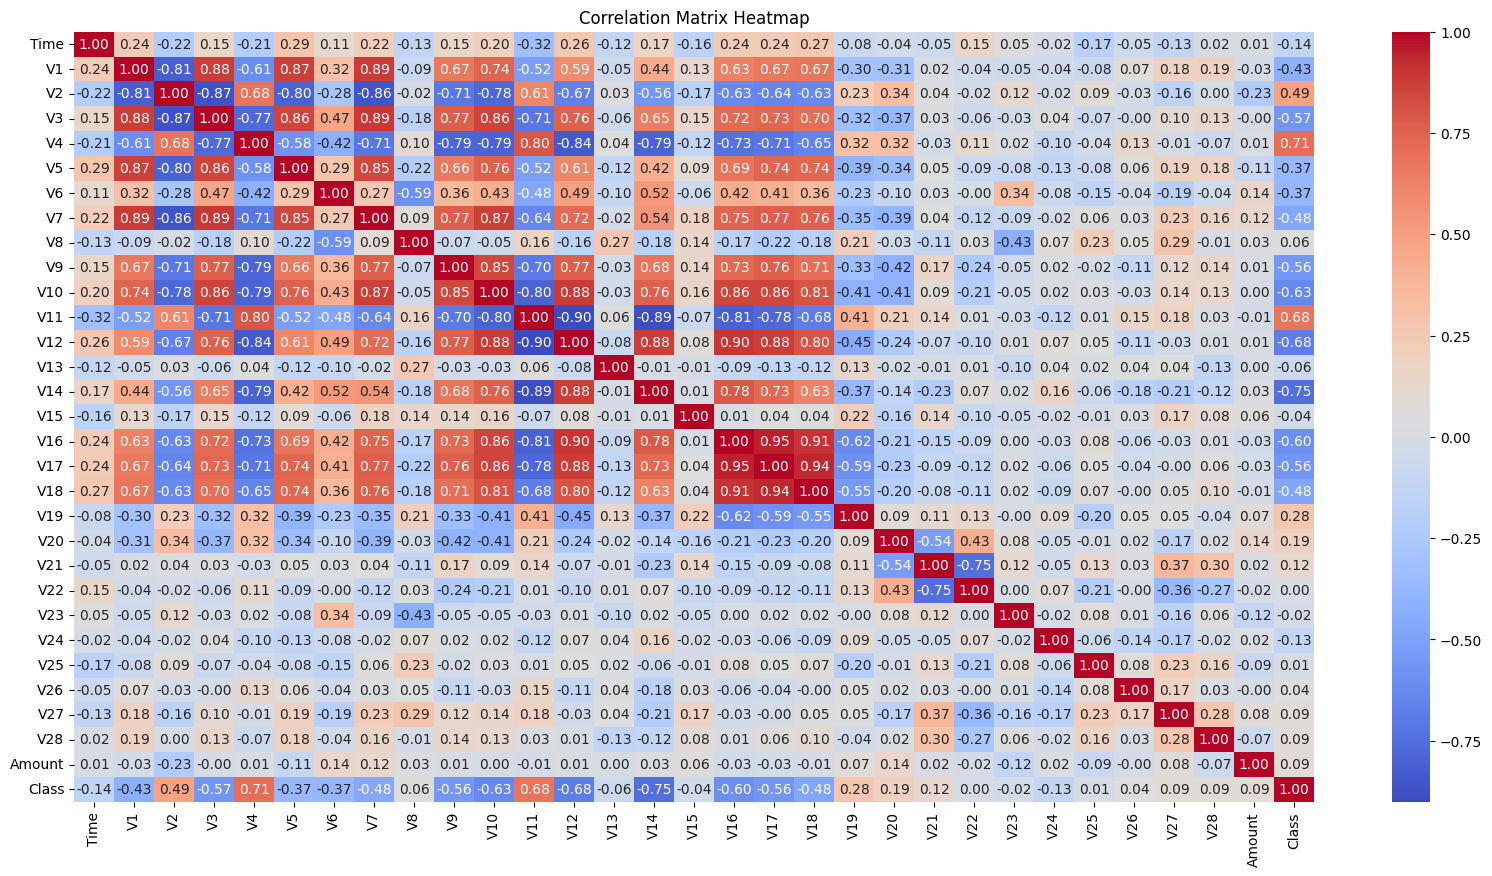

In [10]:
 # get the size of one_labeled dataset
 num_samples = data[data["Class"]==1].shape[0]

undersample_dataset = pd.concat([data[data["Class"]==0].sample(num_samples),
                                 data[data["Class"]==1]], axis=0)

corr = undersample_dataset.corr()
# Create a heatmap using seaborn
plt.figure(figsize=(20, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

[LightGBM] [Info] Number of positive: 492, number of negative: 492
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 984, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


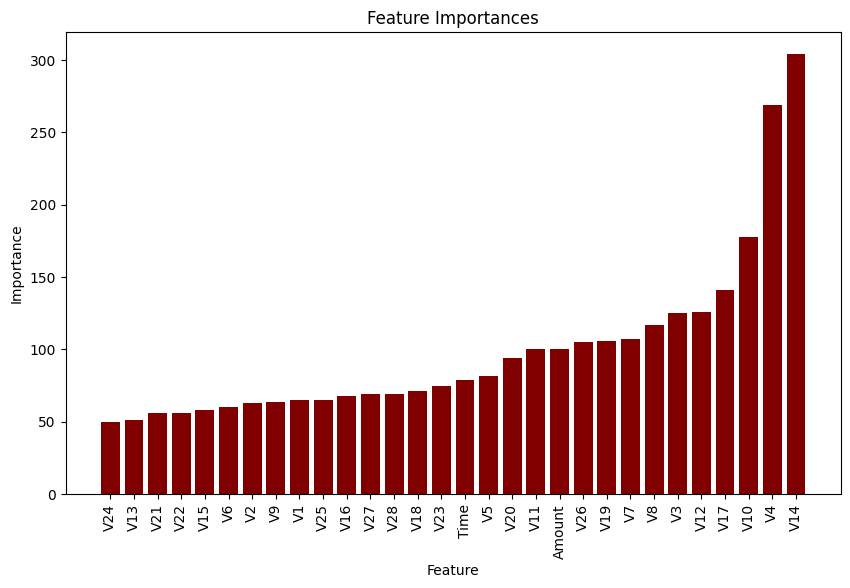

In [11]:
# import light gbm library
import lightgbm as lgb

# Light gbm model definition using basemodel
model_lgbm = lgb.LGBMClassifier(force_col_wise=True)

# prepare features and target for training
X = undersample_dataset.drop("Class", axis=1)
y = undersample_dataset["Class"]

# Light gbm training
model_lgbm.fit(X, y)

# get features importance
feature_importance = [(feature, importance_sore) for feature, importance_sore in zip(X.columns, model_lgbm.feature_importances_)]
feature_importance = sorted(feature_importance, key=lambda x:x[1])
col_names = [col for col, _ in feature_importance]
importance = [score for _, score in feature_importance]

# Create a bar plot of feature importances
plt.figure(figsize=(10, 6))
plt.bar(col_names, importance, color ='maroon')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show();

The chart above draws attention to what most relevant features.

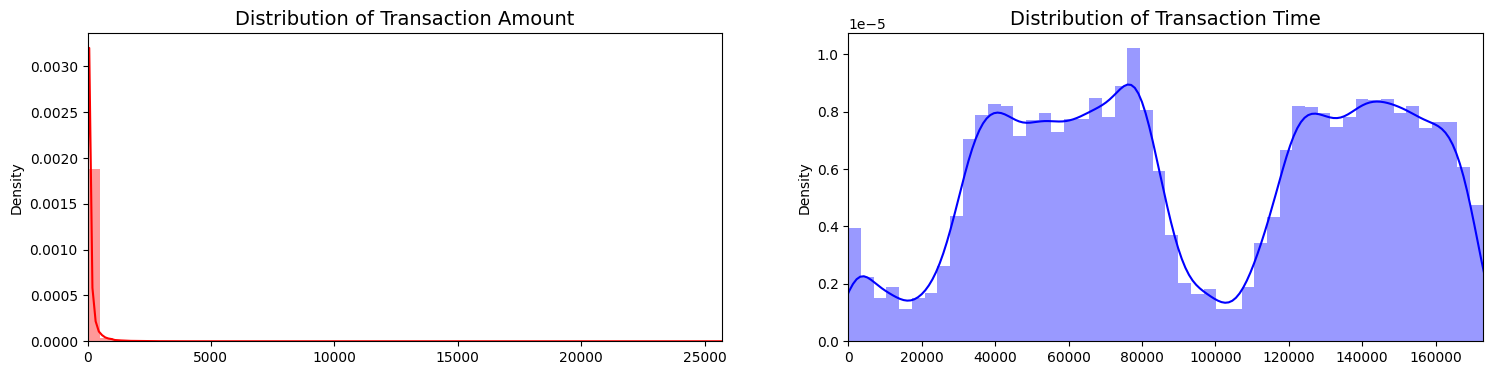

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = data['Amount'].values
time_val = data['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)]);

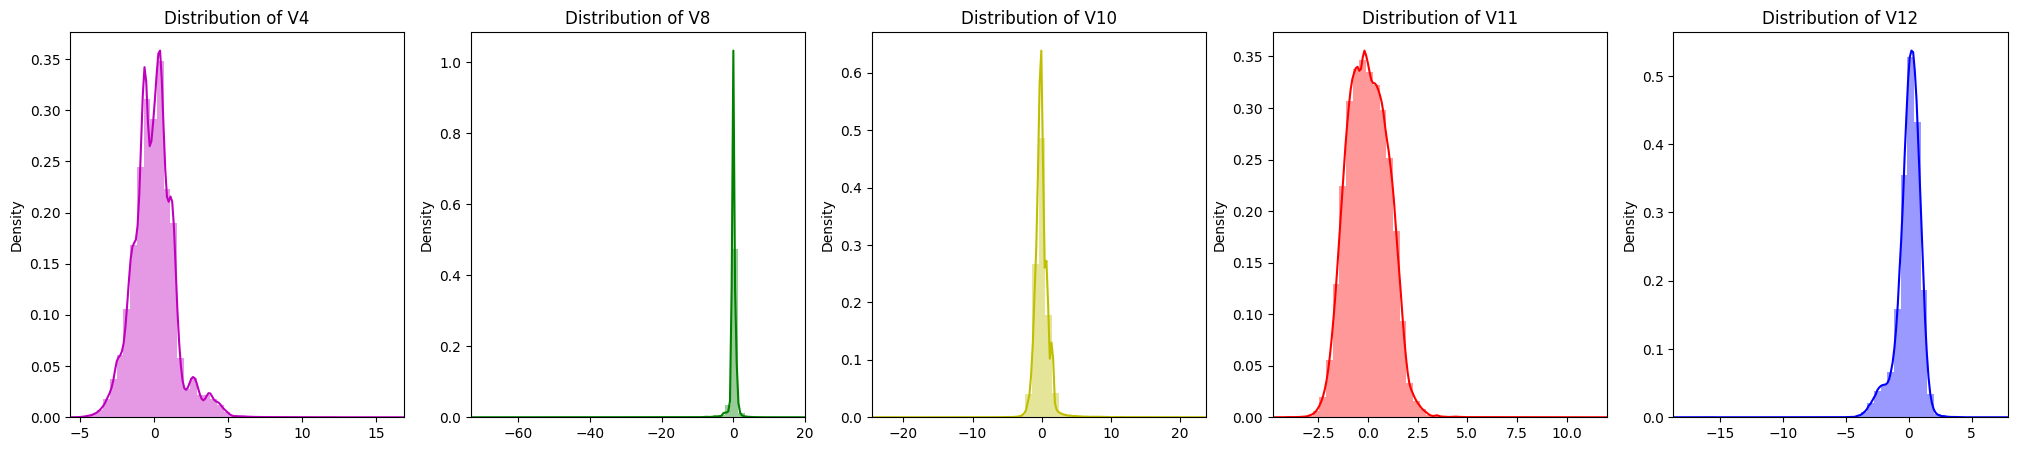

In [13]:
fig, ax = plt.subplots(1, 5, figsize=(25, 5))

V4 = data["V4"].values
V8 = data["V8"].values
V10 = data["V10"].values
V11 = data["V11"].values
V12 = data["V12"].values

sns.distplot(V4, ax=ax[0], color='m')
ax[0].set_title('Distribution of V4', fontsize=12)
ax[0].set_xlim([min(V4), max(V4)]);

sns.distplot(V8, ax=ax[1], color='g')
ax[1].set_title('Distribution of V8', fontsize=12)
ax[1].set_xlim([min(V8), max(V8)])

sns.distplot(V10, ax=ax[2], color='y')
ax[2].set_title('Distribution of V10', fontsize=12)
ax[2].set_xlim([min(V10), max(V10)]);

sns.distplot(V11, ax=ax[3], color='r')
ax[3].set_title('Distribution of V11', fontsize=12)
ax[3].set_xlim([min(V11), max(V11)]);

sns.distplot(V12, ax=ax[4], color='b')
ax[4].set_title('Distribution of V12', fontsize=12)
ax[4].set_xlim([min(V12), max(V12)]);

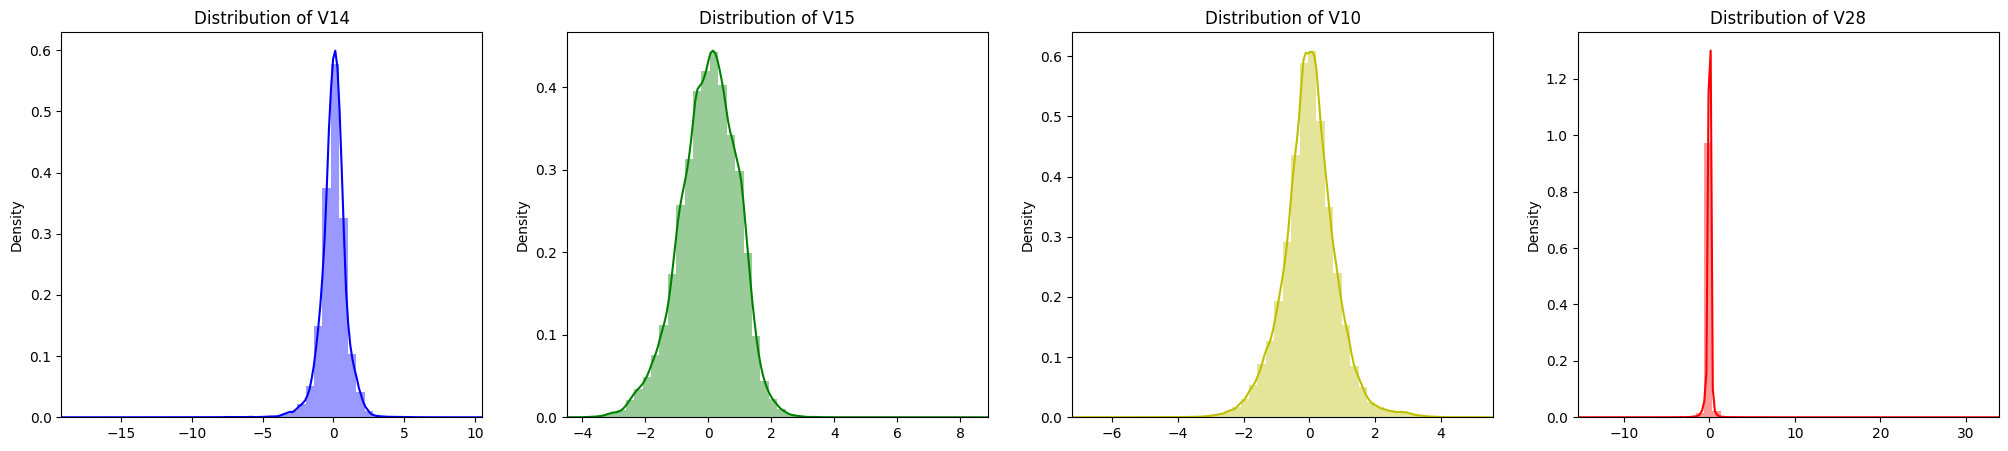

In [14]:
fig, ax = plt.subplots(1, 4, figsize=(25, 5))

V14 = data["V14"].values
V15 = data["V15"].values
V19 = data["V19"].values
V28 = data["V28"].values

sns.distplot(V14, ax=ax[0], color='b')
ax[0].set_title('Distribution of V14', fontsize=12)
ax[0].set_xlim([min(V14), max(V14)]);

sns.distplot(V15, ax=ax[1], color='g')
ax[1].set_title('Distribution of V15', fontsize=12)
ax[1].set_xlim([min(V15), max(V15)])

sns.distplot(V19, ax=ax[2], color='y')
ax[2].set_title('Distribution of V10', fontsize=12)
ax[2].set_xlim([min(V19), max(V19)]);

sns.distplot(V28, ax=ax[3], color='r')
ax[3].set_title('Distribution of V28', fontsize=12)
ax[3].set_xlim([min(V28), max(V28)]);

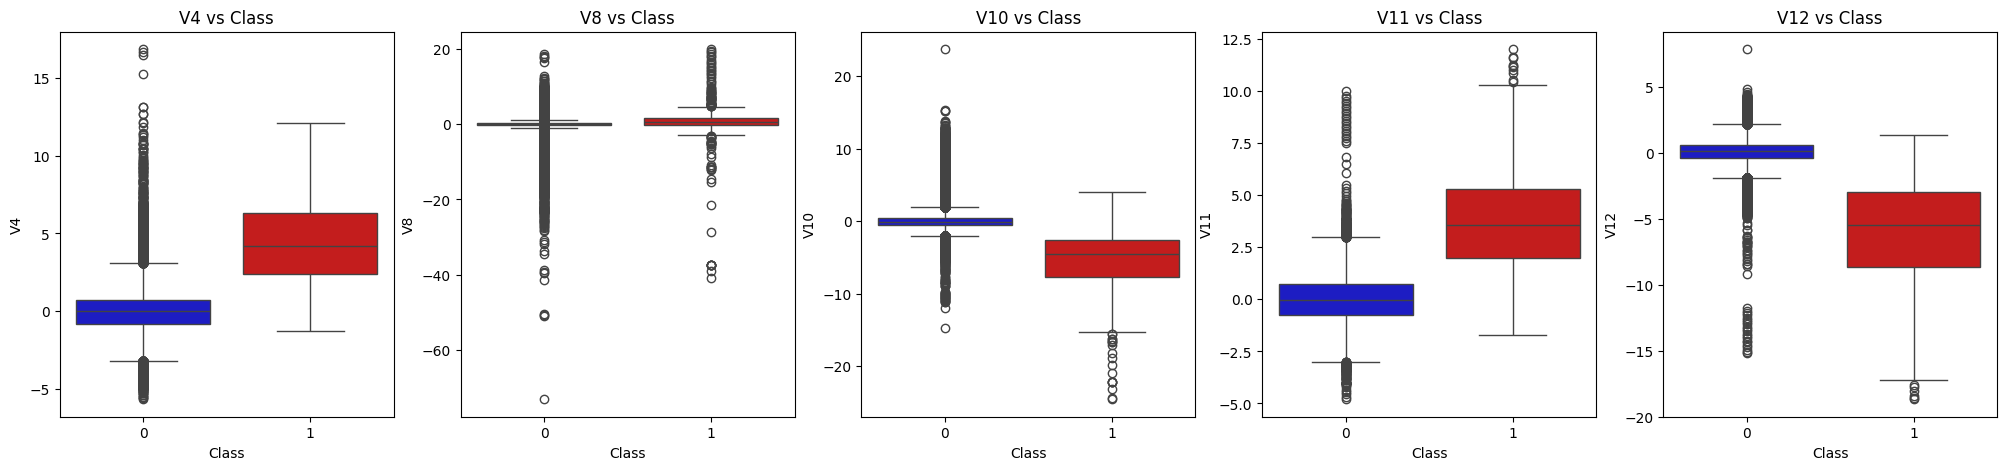

In [15]:
fig, ax = plt.subplots(1, 5, figsize=(25,5))

sns.boxplot(x="Class", y="V4", data=data, palette=colors, ax=ax[0])
ax[0].set_title('V4 vs Class')

sns.boxplot(x="Class", y="V8", data=data, palette=colors, ax=ax[1])
ax[1].set_title('V8 vs Class')

sns.boxplot(x="Class", y="V10", data=data, palette=colors, ax=ax[2])
ax[2].set_title('V10 vs Class')

sns.boxplot(x="Class", y="V11", data=data, palette=colors, ax=ax[3])
ax[3].set_title('V11 vs Class')

sns.boxplot(x="Class", y="V12", data=data, palette=colors, ax=ax[4])
ax[4].set_title('V12 vs Class')

plt.show()

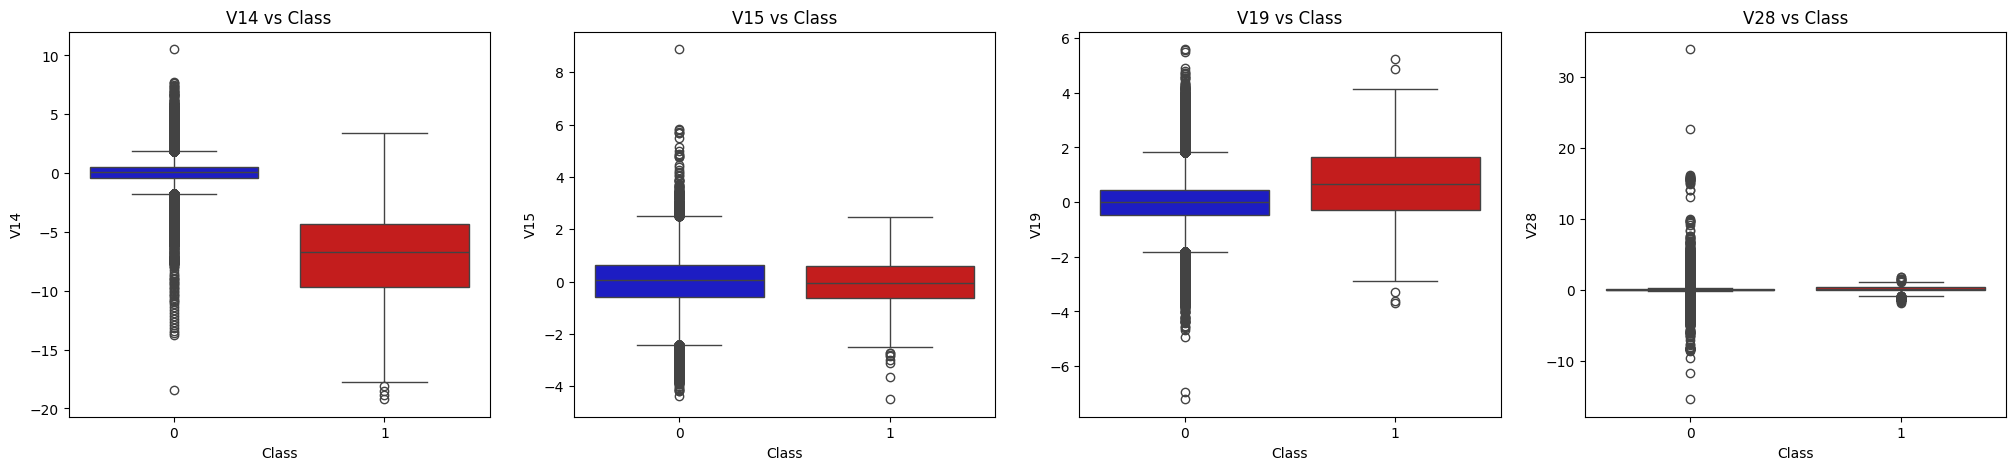

In [16]:
fig, ax = plt.subplots(1, 4, figsize=(25,5))

sns.boxplot(x="Class", y="V14", data=data, palette=colors, ax=ax[0])
ax[0].set_title('V14 vs Class')

sns.boxplot(x="Class", y="V15", data=data, palette=colors, ax=ax[1])
ax[1].set_title('V15 vs Class')

sns.boxplot(x="Class", y="V19", data=data, palette=colors, ax=ax[2])
ax[2].set_title('V19 vs Class')

sns.boxplot(x="Class", y="V28", data=data, palette=colors, ax=ax[3])
ax[3].set_title('V28 vs Class')

plt.show()

The key features contains anomalies that need to be dealt with.

## Data preprocssing

In [17]:
# get the number of anomalies in the dataset
size_of_anomalies = data[data["Class"]==1].shape[0]

# get indices of labeled-zero data
data_label0_indices = data[data['Class']==0].index

# shuffle the list of indices
permutated_indices = np.random.permutation(data_label0_indices)

# divide list of indices into two list
train_indices, cross_validation_indices = permutated_indices[size_of_anomalies:],  permutated_indices[:size_of_anomalies]

# prepare the train set
train_set = (
    data[data['Class']==0].loc[train_indices]
                          .drop("Class", axis=1))

# prepare the cross validation set and the test set
features_labeled0 = (
    data[data['Class']==0].drop("Class", axis=1)
                          .loc[cross_validation_indices]
                          .reset_index(drop=True))

traget_labeled0 = (
    data[data['Class']==0]["Class"].loc[cross_validation_indices]
                                   .reset_index(drop=True))

features_labeled1 = (
    data[data["Class"]==1].drop("Class", axis=1)
                          .reset_index(drop=True))

traget_labeled1 = (
    data[data['Class']==1]["Class"].reset_index(drop=True))


x_cv = pd.concat([features_labeled0, features_labeled1], axis=0)
y_cv = pd.concat([traget_labeled0, traget_labeled1], axis=0)

x_cross_validation, x_test, y_cross_validation, y_test = train_test_split(
     x_cv, y_cv, test_size=0.5, random_state=42)

In [18]:
# remove outliers from the data
def remove_outliers(data, col):
    df = data.copy()

    # to Calculate the Z-score for each value
    median, mean, std = df[col].median(), df[col].mean(), df[col].std()
    z_score = lambda x: (x-mean)/std

    # Define a threshold for outlier detection (e.g., Z-score > 3)
    threshold = 3

    # Remove outliers based on the threshold and replced them with the median
    df[col] = df[col].apply(lambda x: median if z_score(x) > threshold else x)
    return df

# iterate through columns
for col in train_set.columns:
    train_set = remove_outliers(train_set, col)

In [19]:
from sklearn.preprocessing import RobustScaler

# apply RobustScaler on Time columns
scaler1 = RobustScaler()
time = np.array(train_set["Time"]).reshape(-1, 1)
train_set["Time"] = scaler1.fit_transform(time)
x_cross_validation["Time"] =  scaler1.transform(np.array(x_cross_validation["Time"]).reshape(-1, 1))
x_test["Time"] =  scaler1.transform(np.array(x_test["Time"]).reshape(-1, 1))

# apply RobustScaler on Amount columns
scaler2 = RobustScaler()
amount = np.array(train_set["Amount"]).reshape(-1, 1)
train_set["Amount"] = scaler1.fit_transform(amount)
x_cross_validation["Amount"] =  scaler1.transform(np.array(x_cross_validation["Amount"]).reshape(-1, 1))
x_test["Amount"] =  scaler1.transform(np.array(x_test["Amount"]).reshape(-1, 1))

All V1 to V28 features have been transformed using PCA and are assumed to be standardized, requiring us to also standardize the Time and Amount variables.

## Modeling

In [20]:
from sklearn.neighbors import KernelDensity

class AnomalyDetector(KernelDensity):
     def __init__(self, kernel='gaussian', bandwidth=1, threshold=50):
         super().__init__(kernel=kernel, bandwidth=bandwidth)
         self.threshold = threshold

     def predict_score(self, X):
         return np.abs(self.score_samples(X))

     def predict_class(self, X):
         return self.predict_score(X) > self.threshold

# initialize model object with the default parameters
model = AnomalyDetector()
# train the model
model.fit(train_set)
# get probability prodictions
y_scores = model.predict_score(x_cross_validation)
# get class predictions
y_pred = model.predict_class(x_cross_validation)

In [21]:
# show accuracy score on train_set
indices = data[data['Class']==0].index
random_indices = np.random.choice(train_set.index, size=500)
y_train = np.zeros(500)
y_train_pred = model.predict_class(train_set.loc[random_indices])
print(f"training_set accuracy_score: {accuracy_score(y_train, y_train_pred)}")

training_set accuracy_score: 1.0


The Anomaly Detector Model fits well on training set.

In [22]:
# diplay classification report on CV data
print(classification_report(y_cross_validation, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89       239
           1       0.97      0.79      0.87       253

    accuracy                           0.88       492
   macro avg       0.89      0.88      0.88       492
weighted avg       0.89      0.88      0.88       492



In [23]:
def confusion_matrix_display(y_true, y_pred):
    con_mat = confusion_matrix(y_true, y_pred)
    sns.heatmap(con_mat, annot=True, fmt=".2f", cmap='coolwarm')
    plt.xlabel("Predictions")
    plt.ylabel("True labels")
    plt.title("Predictions Vs True labels");

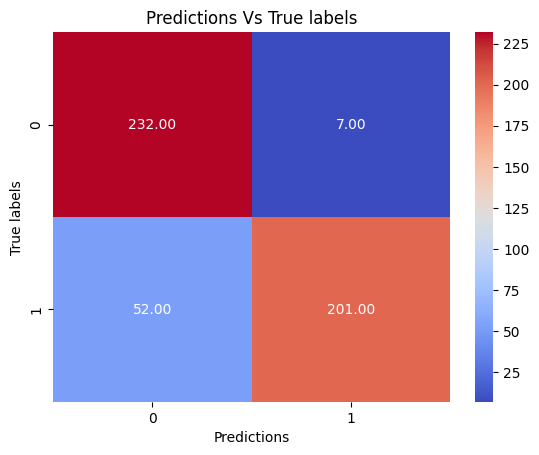

In [24]:
confusion_matrix_display(y_cross_validation, y_pred)

However, the model's performance on the cross-validation set was poor.

We should look for better **threshold**.

In [25]:
params_grid = {"thresholds": [sorted(y_scores)[i] for i in range(0, len(y_scores), 15)]}

class CustomGridSearchCV:
    def __init__(self, estimator, params_grid):
        self.estimator = estimator
        self.params_grid = params_grid

    def best_params(self, x_cross_validation, y_cross_validation):
        F1, best_F1, best_threshold = (0, 0, 0)

        for threshold in tqdm(self.params_grid["thresholds"]):
            self.estimator.threshold=threshold
            y_pred = model.predict_class(x_cross_validation)
            F1 = f1_score(y_cross_validation, y_pred)
            if F1 > best_F1:
                best_F1 = F1
                best_threshold = threshold

        return {"best_F1":best_F1, "best_threshold":best_threshold}

cgs = CustomGridSearchCV(model, params_grid)
results = cgs.best_params(x_cross_validation, y_cross_validation)
results

100%|██████████| 33/33 [16:21<00:00, 29.75s/it]


{'best_F1': 0.9087301587301587, 'best_threshold': 41.16254468820797}

In [26]:
# get classification report on cross validation set
model = AnomalyDetector(threshold=results["best_threshold"])
model.fit(train_set)
y_pred_cv = model.predict_class(x_cross_validation)
print(classification_report(y_cross_validation, y_pred_cv))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89       239
           1       0.90      0.91      0.90       253

    accuracy                           0.90       492
   macro avg       0.90      0.90      0.90       492
weighted avg       0.90      0.90      0.90       492



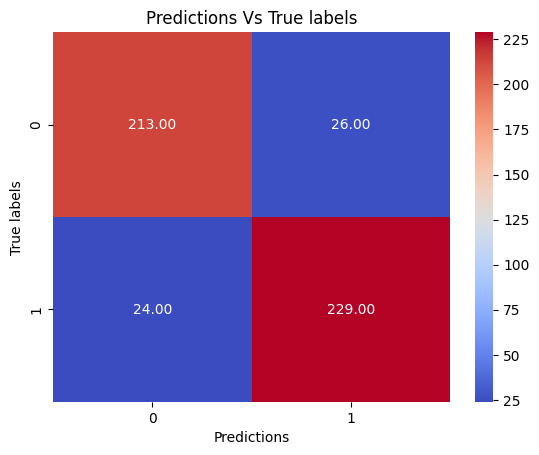

In [27]:
confusion_matrix_display(y_cross_validation, y_pred_cv)

In [28]:
# get classification report on test set
y_pred_test = model.predict_class(x_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       253
           1       0.91      0.91      0.91       239

    accuracy                           0.91       492
   macro avg       0.91      0.91      0.91       492
weighted avg       0.91      0.91      0.91       492



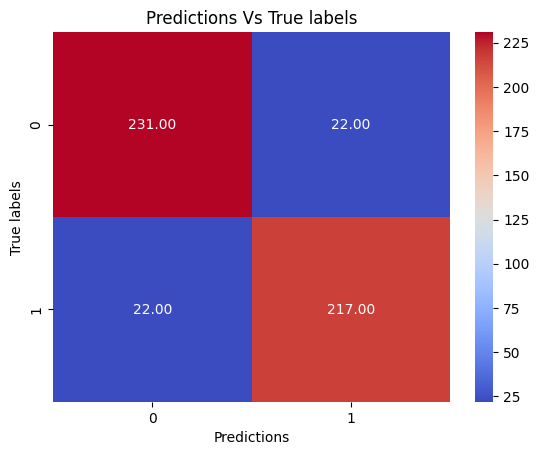

In [29]:
confusion_matrix_display(y_test, y_pred_test)

              precision    recall  f1-score   support

           0       0.94      0.82      0.88       253
           1       0.83      0.95      0.89       239

    accuracy                           0.88       492
   macro avg       0.89      0.88      0.88       492
weighted avg       0.89      0.88      0.88       492



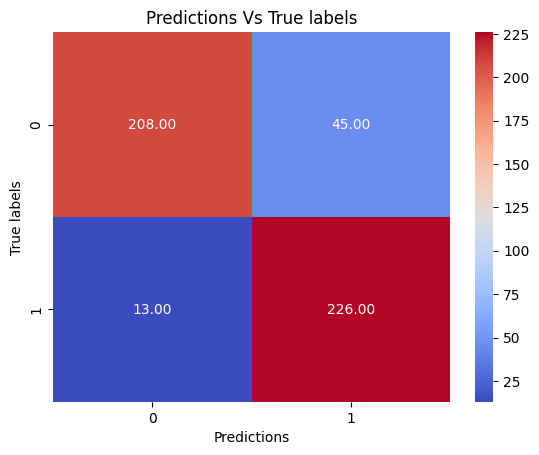

In [30]:
model = AnomalyDetector(threshold=39)
model.fit(train_set)

# get classification report on test set
y_pred_test = model.predict_class(x_test)
print(classification_report(y_test, y_pred_test))

confusion_matrix_display(y_test, y_pred_test)

If we aim to achieve high recall for class 1, we can lower the threshold, but this will result in lower recall for class 0.